In [1]:
from config import setup, import_and_display_fnc

setup()

# Fault-surface intersection and infinite free surfaces.

**This is a very rough draft**

In the last section, we constructed a method for solving for surface displacement on a free surface given antiplane slip on a fault beneath the free surface. However, the fault was not allowed to intersect the surface of the Earth. In fact, as we will demonstrate here, if the fault had intersected the surface, the surface displacement solution would have been very wrong! In this section, we will fix this problem!

In addition, the last section compared against an analytical solution that assumes an infinite free surface. Unfortunately, we weren't able to match the analytical solution exactly because it's hard to approximate an infinite free surface. It would be easy to stop there and make a compelling argument that the numerical method is working just fine since the error was quite low away from the tips of the free surface. But that didn't leave me satisfied. I want to fit the arctan solution as exactly as possible!

So, our goals in this section are to:
1. Model a fault that intersects the surface of the Earth.
2. Model an infinite free surface to the best of our ability.

Both of these goals will lead to more general methods that are useful for a wide range of problems. In particular, modeling an infinite free surface will force us to implement some **adaptive meshing** tools that will be very useful for other problems where the spatial scale of interest varies widely through the domain. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from common import (
    gauss_rule,
    qbx_matrix,
    symbolic_eval,
    build_interp_matrix,
    build_interpolator,
    qbx_setup,
    double_layer_matrix,
)

## Panels

The key to solving both these problem will be to separate the surface into many smaller components that we will call "panels". Up until now, every surface we've dealt with has been parameterized with a single curve and then discretized using a single quadrature rule, either Gaussian or trapezoidal. Why does separating this single surface into subcomponents help?
1. A Gaussian quadrature rule implicitly assumes that the function being integrated is smooth. However, at a fault-surface intersection, the surface displacement will actually be discontinuous! 
2. The resolution needed near the fault will be high. The resolution needed 100 fault lengths away from the fault trace is very low. So, we will need to have higher point density in some places than others. We will achieve this by refining some panels to be much smaller than others. 

[draft note] Explain the code below more. 

In [3]:
from dataclasses import dataclass

# Hierarchy: Boundary -> Element -> Panel -> Point
# A boundary consists of several segments.
# An element consists of a single parametrized curve that might be composed of several panels.
# A panel consists of a quadrature rule defined over a subset of a parametrized curve.
@dataclass()
class PanelSurface:
    quad_pts: np.ndarray
    quad_wts: np.ndarray
    pts: np.ndarray
    normals: np.ndarray
    jacobians: np.ndarray
    panel_bounds: np.ndarray
    panel_start_idxs: np.ndarray
    panel_sizes: np.ndarray

    @property
    def n_pts(self):
        return self.pts.shape[0]

    @property
    def n_panels(self):
        return self.panel_bounds.shape[0]


def panelize_symbolic_surface(t, x, y, panel_bounds, qx, qw):
    """
    Construct a surface out of a symbolic parametrized curve splitting the curve parameter at 
    `panel_bounds` into subcomponent. `panel_bounds` is expected to be a list of ranges of 
    the parameter `t` that spans from [-1, 1]. For example:
    `panel_bounds = [(-1,-0.5),(-0.5,0),(0,1)]` would split the surface into three panels extending from
    1. t = -1 to t = -0.5
    2. t=-0.5 to t=0 
    3. t=0 to t=1.
    """
    dxdt = sp.diff(x, t)
    dydt = sp.diff(y, t)

    jacobian = sp.simplify(sp.sqrt(dxdt ** 2 + dydt ** 2))

    nx = -dydt / jacobian
    ny = dxdt / jacobian

    quad_pts = []

    panel_width = panel_bounds[:, 1] - panel_bounds[:, 0]

    quad_pts = (
        panel_bounds[:, 0, None] + panel_width[:, None] * (qx[None, :] + 1) * 0.5
    ).flatten()
    quad_wts = (panel_width[:, None] * qw[None, :] * 0.5).flatten()
    surf_vals = [symbolic_eval(t, quad_pts, v) for v in [x, y, nx, ny, jacobian]]

    # And corner_resolutioneate the surface object.
    pts = np.hstack((surf_vals[0][:, None], surf_vals[1][:, None]))
    normals = np.hstack((surf_vals[2][:, None], surf_vals[3][:, None]))
    jacobians = surf_vals[4]

    panel_sizes = np.full(panel_bounds.shape[0], qx.shape[0])
    panel_start_idxs = np.cumsum(panel_sizes) - qx.shape[0]

    return PanelSurface(
        quad_pts,
        quad_wts,
        pts,
        normals,
        jacobians,
        panel_bounds,
        panel_start_idxs,
        panel_sizes,
    )


def build_panel_interp_matrix(surface_in, surface_out):
    """
    Construct a matrix interpolating the values of some function from surface_in 
    to surface_out. The function assumes that underlying surface is the same 
    between both surfaces and that the number of panels is the same. The only 
    difference is the order of approximation on each panel.
    """
    out = np.zeros((surface_out.n_pts, surface_in.n_pts))
    for i in range(surface_in.n_panels):
        n_in = surface_in.panel_sizes[i]
        start_in = surface_in.panel_start_idxs[i]
        end_in = start_in + n_in

        n_out = surface_out.panel_sizes[i]
        start_out = surface_out.panel_start_idxs[i]
        end_out = start_out + n_out

        in_quad_pts = surface_in.quad_pts[start_in:end_in]
        out_quad_pts = surface_out.quad_pts[start_out:end_out]
        chunk = build_interp_matrix(build_interpolator(in_quad_pts), out_quad_pts)
        out[start_out:end_out, start_in:end_in] = chunk
    return out

This next section will construct the free surface panelized surface `flat`. The `corner_resolution` specifies how large the panels will be near the fault-surface intersection. Away from that intersection, the panels will each be double the length of the prior panel, thus enabling the full surface to efficiently represent an effectively infinite free surface. 

In [4]:
from common import Surface
import sympy as sp

corner_resolution = 0.5
n_panels = 20

# It seems that we need several "small" panels right near the fault-surface intersection!
panels = [
    (-3 * corner_resolution, -2 * corner_resolution),
    (-2 * corner_resolution, -corner_resolution),
    (-corner_resolution, 0),
    (0, corner_resolution),
    (corner_resolution, 2 * corner_resolution),
    (2 * corner_resolution, 3 * corner_resolution),
]
for i in range(n_panels - len(panels)):
    panel_start = panels[-1][1]
    panel_end = panel_start + corner_resolution * (2 ** i)
    panels.append((panel_start, panel_end))
    panels.insert(0, (-panel_end, -panel_start))
panels = np.array(panels)
scaled_panels = panels / panels[-1][1]

qx, qw = gauss_rule(16)
qinterp = gauss_rule(96)
t = sp.var("t")

flat = panelize_symbolic_surface(t, -panels[-1][1] * t, 0 * t, scaled_panels, qx, qw)
flat_interp = panelize_symbolic_surface(
    t, panels[-1][1] * t, 0 * t, scaled_panels, *qinterp
)
Im_flat = build_panel_interp_matrix(flat, flat_interp)

In the figure below, I plot $log_{10}(x)$ against the point index. You can see that the spacing of points is much finer near the fault surface intersection and rapidly increases away from the fault surface intersection.

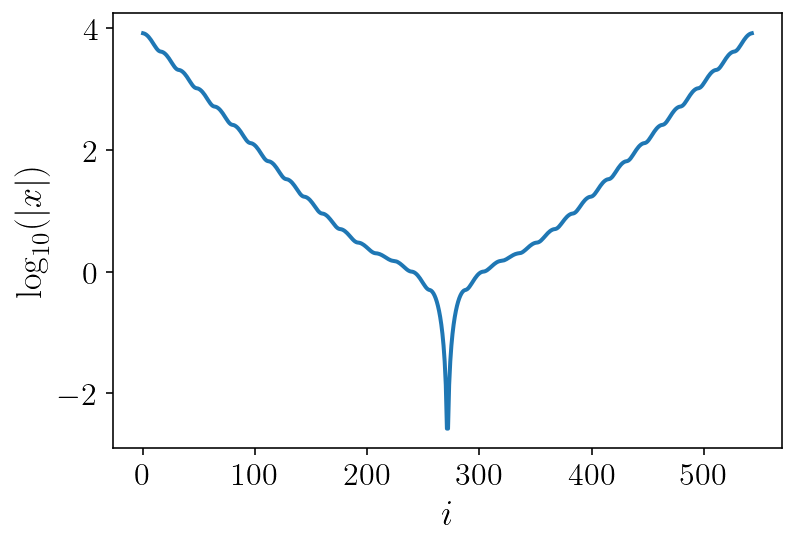

In [5]:
plt.plot(np.log10(np.abs(flat.pts[:,0])))
plt.xlabel(r'$i$')
plt.ylabel(r'$\log_{10}(|x|)$')

plt.show()

We do a similar construction with the fault panels so that the density of quadrature points is much higher near the intersection.

In [6]:
fault_top = -0.0
fault_bottom = -1.0

fault_panels = [
    (0, 0.5 * corner_resolution),
    (0.5 * corner_resolution, 1.0 * corner_resolution),
    (1.0 * corner_resolution, 1.5 * corner_resolution),
    (1.5 * corner_resolution, 2 * corner_resolution),
]
for i in range(100):
    panel_start = fault_panels[-1][1]
    panel_end = panel_start + 2 * corner_resolution * (2 ** i)
    if panel_end > fault_bottom * 0.75:
        panel_end = -fault_bottom
    fault_panels.append((panel_start, panel_end))
    panel_start = panel_end
    if panel_end == -fault_bottom:
        break
fault_panels = np.array(fault_panels)
scaled_fault_panels = 2 * ((fault_panels / fault_panels[-1][1]) - 0.5)
fault = panelize_symbolic_surface(
    t, 0 * t, -fault_panels[-1][1] * (t + 1) * 0.5, scaled_fault_panels, qx, qw
)

Next, we need to carefully remove some of the QBX expansion centers. Because the expansion centers are offset towards the interior of the domain in the direction of the normal vector of the free surface, a few of them will be too close to the fault surface. We remove those. As a result, any evaluations in the corner will use the slightly farther away QBX expansion points. 

In the figure below, the QBX expansion centers are indicated in blue, while the expansion centers that we remove are indicated in red. 

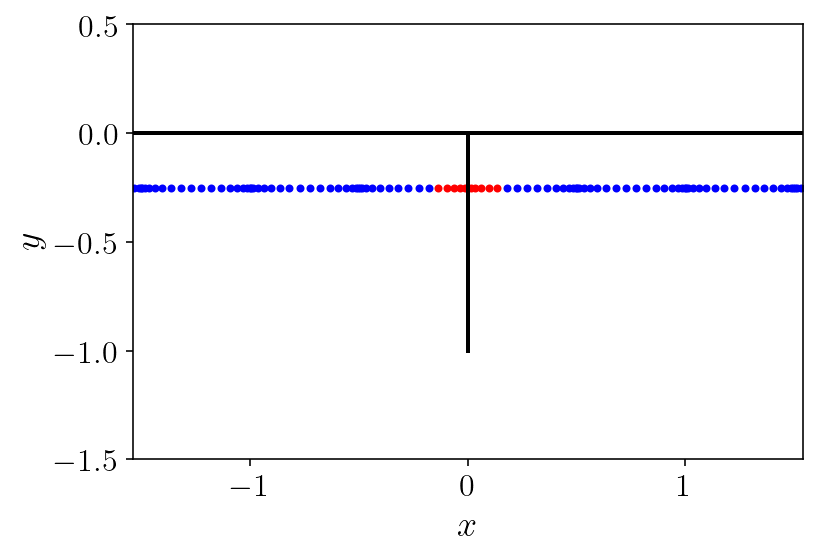

In [7]:
from common import QBXExpansions

r = (
    np.repeat((flat.panel_bounds[:, 1] - flat.panel_bounds[:, 0]), flat.panel_sizes)
    * flat.jacobians
    * 0.5
)
orig_expansions = qbx_setup(flat, direction=1, r=r, p=10)
good = np.abs(orig_expansions.pts[:, 0]) > 0.30 * corner_resolution
expansions = QBXExpansions(
    orig_expansions.pts[good, :], orig_expansions.r[good], orig_expansions.p
)

plt.plot(expansions.pts[:, 0], expansions.pts[:, 1], "b.")
plt.plot(orig_expansions.pts[~good, 0], orig_expansions.pts[~good, 1], "r.")
plt.plot(flat.pts[:, 0], flat.pts[:, 1], "k-")
plt.plot(fault.pts[:, 0], fault.pts[:, 1], "k-")
plt.axis("equal")
plt.xlim([-corner_resolution, corner_resolution])
plt.ylim([-3 * corner_resolution, corner_resolution])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

Note that despite extending out to 1000 fault lengths away from the fault trace, we are only using 672 points to describe the free surface solution. 

In [8]:
print('number of points in the free surface discretization:', flat.n_pts)
print('       number of points in the fault discretization:', fault.n_pts)

number of points in the free surface discretization: 544
       number of points in the fault discretization: 80


In [9]:
A_raw = qbx_matrix(double_layer_matrix, flat_interp, flat.pts, expansions)[:, 0, :]
A = A_raw.dot(Im_flat)

In [10]:
B = -qbx_matrix(double_layer_matrix, fault, flat.pts, expansions)[:, 0, :]

In [11]:
surf_disp = np.linalg.solve(np.eye(A.shape[0]) + A, B.dot(np.ones(fault.n_pts)))

# Note that the analytical solution is slightly different than in the buried 
# fault setting because we need to take the limit of an arctan as the 
# denominator of the argument  goes to zero.
s = 1.0
analytical = (
    -s
    / (2 * np.pi)
    * (
        np.arctan(flat.pts[:, 0] / (flat.pts[:, 1] - fault_bottom))
        - np.arctan(flat.pts[:, 0] / (flat.pts[:, 1] + fault_bottom))
        - np.pi * np.sign(flat.pts[:, 0])
    )
)

In the first row of graphs below, I show the solution extending to 10 fault lengths. In the second row, the solution extends to 1000 fault lengths. You can see that the solution matches to about 6 digits in the nearfield and 7-9 digits in the very farfield!

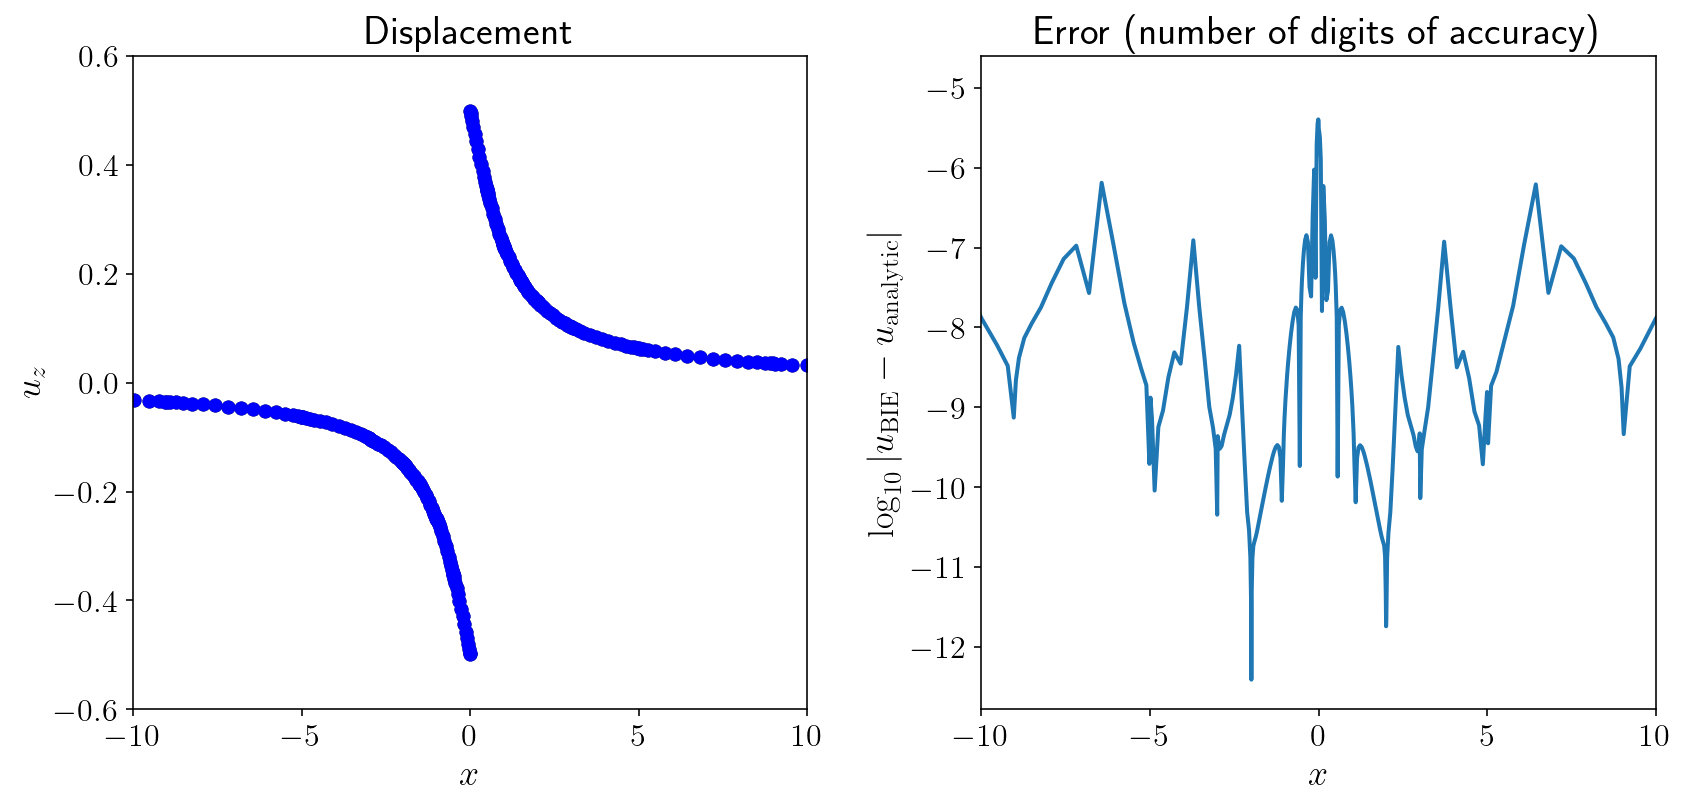

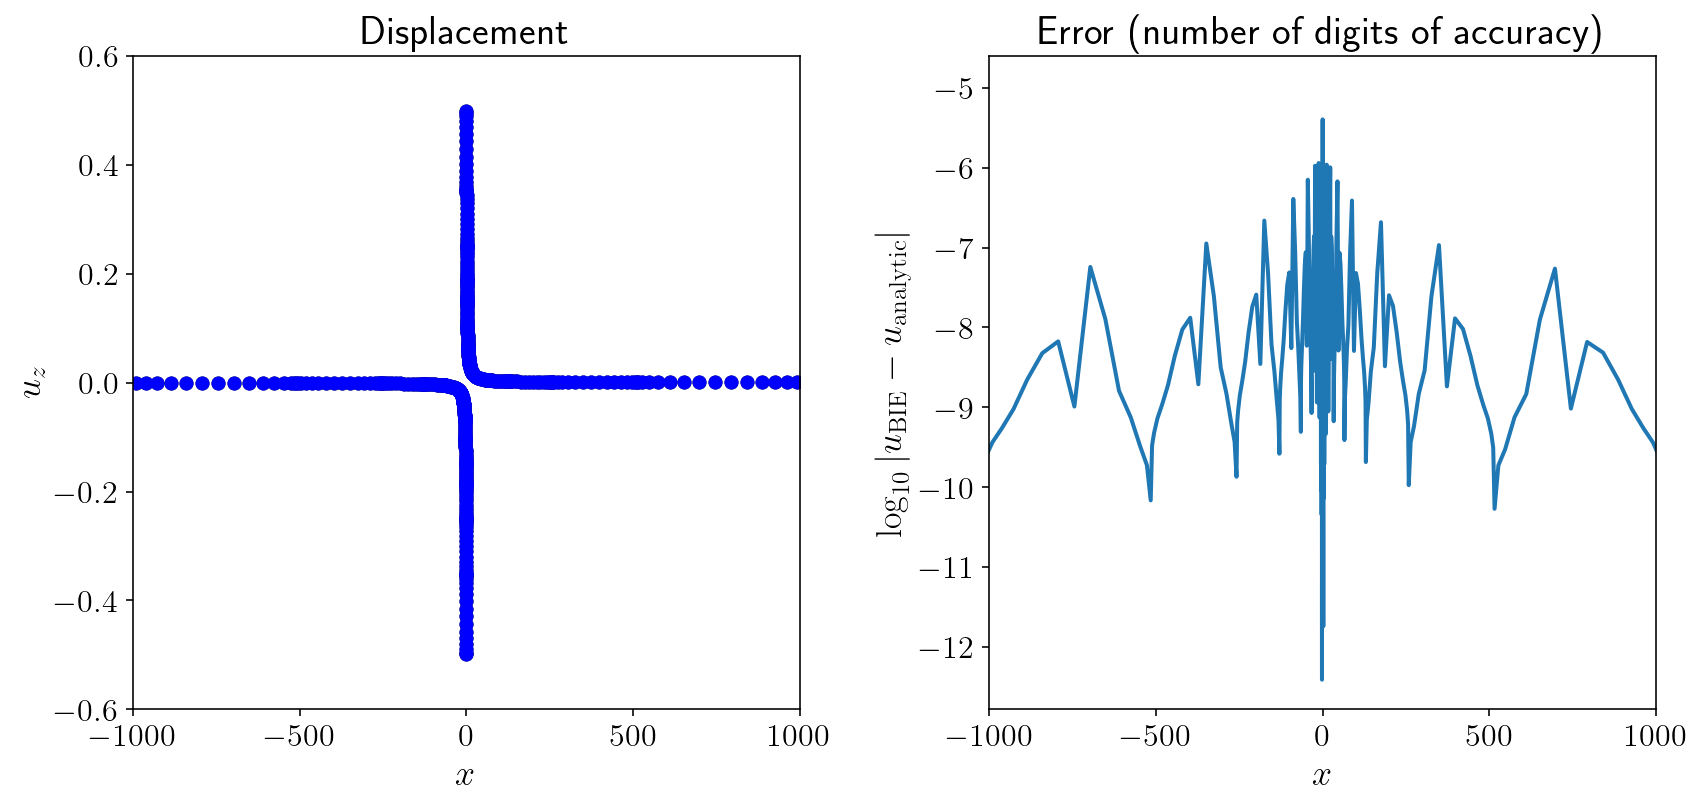

In [14]:
for XV in [10.0, 1000.0]:
    # XV = 5 * corner_resolution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(flat.pts[:, 0], surf_disp, "ko")
    plt.plot(flat.pts[:, 0], analytical, "bo")
    plt.xlabel("$x$")
    plt.ylabel("$u_z$")
    plt.title("Displacement")
    plt.xlim([-XV, XV])
    plt.ylim([-0.6, 0.6])

    plt.subplot(1, 2, 2)
    plt.plot(flat.pts[:, 0], np.log10(np.abs(surf_disp - analytical)))
    plt.xlabel("$x$")
    plt.ylabel(r"$\log_{10}|u_{\textrm{BIE}} - u_{\textrm{analytic}}|$")
    plt.title("Error (number of digits of accuracy)")
    plt.tight_layout()
    plt.xlim([-XV, XV])
    plt.show()